# Table of content
1. [Define methods](#Define-methods)
1. [Data Prepocessing](#Data-Prepocessing)
   1. [Data initialization](#Data-initialization)
   1. [First exploration](#First-exploration)
   1. [Feature engineering methods](#Feature-engineering-methods)
   1. [Data size & Features model selection](#Data-size-&-Features-model-selection)
1. [Data exploration](#Data-exploration)
   1. [Algorithm](#Algorithm)
1. [Miscellaneous](#Miscellaneous)
   

In [1]:
from math import sqrt, log
import datetime
import numpy as np
from numpy.linalg import inv
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from random import shuffle
import pandas as pd
import mglearn
import xgboost
%matplotlib inline
sns.set()
from sklearn import decomposition
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.cluster import AgglomerativeClustering, DBSCAN

# Define methods

In [2]:
l = list
p = print
pt = lambda x: print(type(x))
rl = lambda x: range(len(x))
a = np.array
best_weight = [0.025212  ,  0.01268883,  0.02279309,  0.0166642 ,  0.02068468,\
               0.01387662,  0.00096794,  0.01963766,  0.01831665,  0.01984297,\
               0.02039621,  0.02253402, -0.01003976,  0.01767089,  0.01893632,\
               0.01475718,  0.02210797,  0.01855322,  0.01960163,  0.01261731,\
               0.02288718,  0.02191818,  0.02140918,  0.02156594,  0.02245936,\
               0.02502659,  0.02793214,  0.02647139,  0.02745684,  0.02011473,\
               0.0264149 ,  0.02993924,  0.03572745,  0.03245962, -0.00197627,\
               0.04564757,  0.03690009,  0.04765921,  0.05152177,  0.0674441]

def score_function(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# wraps scoring functions for use in GridSearchCV and cross_val_score.
mape = make_scorer(score_function, greater_is_better=False)


def print_results(estimator, preprocess_func=lambda x:x, log = True):
    score_train = score_function(y_train, estimator.predict(preprocess_func(X_train)))
    score_test = score_function(y_test, estimator.predict(preprocess_func(X_test)))
    print("best_params",estimator.best_params_)
    print("train: ", score_train)
    print("test: ", score_test)
    if log and len(current_train) >= 10000:
        features = ""
        cols = set(X_train.columns)
        if cols != cols - set(["product_id"]):
            cols -=  set(["product_id"])
            features += "id:"
        if cols != cols - set(vol_names):
            cols -= set(vol_names)
            features += "vol:"
        if cols != cols - set(return_names):
            cols -= set(return_names)
            features += "ret:"
        for col in cols:
            features += col + ":"
        features if features else feature_method.__name__
        with open('results.log', 'a') as the_file:
            the_file.write("| " +datetime.datetime.today().strftime("%d/%m/%y - %H:%M"))
            the_file.write(" | " + features)
            the_file.write(" | " + "_".join([str(est[1]).split("(")[0] for est in estimator.estimator.steps]))            
            the_file.write(" | " + str(len(current_train)) + ":" + str(1 - test_size))
            the_file.write(" | " + str(score_train))
            the_file.write(" | " + str(score_test))
            the_file.write("|\n")

import multiprocessing as mp
def _apply_df(args):
    df, func, num, kwargs = args
    return num, df.apply(func, **kwargs)

def multiprocessed_apply(df,func,**kwargs):
    workers = 4
    pool = mp.Pool(processes=workers)
    chunks = [(d, func, i, kwargs) for i,d in enumerate(np.array_split(df, workers))]
    result = pool.map(_apply_df, chunks)
    pool.close()
    result=sorted(result,key=lambda x:x[0])
    return pd.concat([i[1] for i in result])

def correlation_matrix(df):
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

def new_feature(name, func, data_set):
    if len(data_set) == len(test):
        return multiprocessed_apply(data_set, func, axis=1)
    if name in train_all_feature.columns:
        return train_all_feature.loc[data_set.index, name]
    else:
        series = multiprocessed_apply(data_set, func, axis=1)
        if not work_with_subset:
            train_all_feature[name] = series
        return series

feature_method = lambda x:x
def df_to_csv(df, name):
    pd.DataFrame({"TARGET":df}).to_csv('./output/' + name + '.csv', sep=';', index=True)
def test_to_csv(estimator, preprocess_func=feature_method, name="out"):
    a = pd.DataFrame({ 'ID':test.index, 'TARGET':estimator.predict(preprocess_func(test))})
    a.to_csv('./output/' + name + '.csv', sep=';', index=False)



# Data Prepocessing 

### Data initialization

In [66]:
# training set: X
train = pd.read_csv('data/training_input.csv', sep=";")
train.index = train['ID']
train = train.drop('ID',1)
train_all_feature = train
# results of the training set: Y
result = pd.read_csv('data/challenge_output_data_training_file_volatility_prediction_in_financial_markets.csv', sep=";")
result.index = result['ID']
result = result['TARGET']
# score data set 
test = pd.read_csv('data/testing_input.csv', sep=";")
test.index = test['ID']
test = test.drop('ID',1)

vol_names = train.columns[2:56]
return_names = train.columns[56:]

def fill_nan(df):
    medians_vol = df[vol_names].T.median()
    medians_return = df[return_names].T.median()
    df[vol_names] = df[vol_names].fillna({name:medians_vol for name in vol_names})
    df[return_names] = df[return_names].fillna({name:medians_return for name in return_names})
fill_nan(train)
fill_nan(test)
train = train.where((pd.notnull(train)), 0)
test = test.where((pd.notnull(test)), 0)

# check if there are NaN cells
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
p(NAs[NAs.sum(axis=1) > 0])

print(len(train), len(result), len(test))
train.info()

Empty DataFrame
Columns: [Train, Test]
Index: []
636313 636313 635397
<class 'pandas.core.frame.DataFrame'>
Int64Index: 636313 entries, 1 to 636313
Columns: 110 entries, date to return 13:55:00
dtypes: float64(108), int64(2)
memory usage: 538.9 MB


In [4]:
train.describe()

,date,product_id,volatility 09:30:00,volatility 09:35:00,volatility 09:40:00,volatility 09:45:00,volatility 09:50:00,volatility 09:55:00,volatility 10:00:00,volatility 10:05:00,...,return 13:10:00,return 13:15:00,return 13:20:00,return 13:25:00,return 13:30:00,return 13:35:00,return 13:40:00,return 13:45:00,return 13:50:00,return 13:55:00
count,636313.000000,636313.000000,636313.000000,636313.000000,636313.000000,636313.000000,636313.000000,636313.000000,636313.000000,636313.000000,...,636313.000000,636313.000000,636313.000000,636313.000000,636313.000000,636313.000000,636313.000000,636313.000000,636313.000000,636313.000000
mean,1059.128210,160.248984,0.566130,0.472403,0.405321,0.360220,0.334165,0.306628,0.336073,0.292918,...,-0.004824,0.022003,0.002111,0.001244,-0.007823,-0.012777,-0.002660,0.001954,-0.008490,-0.008299
std,610.501769,92.014489,0.635065,0.494674,0.436578,0.377392,0.356376,0.323326,0.343210,0.314783,...,0.901810,0.903271,0.903783,0.903393,0.907617,0.906511,0.906523,0.907482,0.907369,0.908926
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,531.000000,81.000000,0.210037,0.188604,0.161670,0.142201,0.129127,0.118961,0.131550,0.113127,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,1058.000000,161.000000,0.405610,0.341686,0.292415,0.258592,0.236936,0.219062,0.239057,0.207835,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1589.000000,241.000000,0.717135,0.594259,0.508577,0.452680,0.418686,0.386758,0.422289,0.368523,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2117.000000,318.000000,46.463028,22.345580,27.829934,18.600202,16.226835,20.255632,11.413828,17.792948,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### First exploration

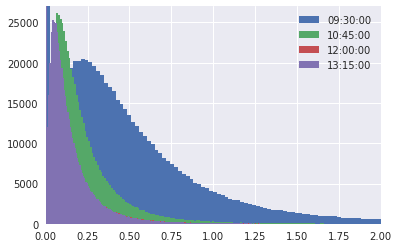

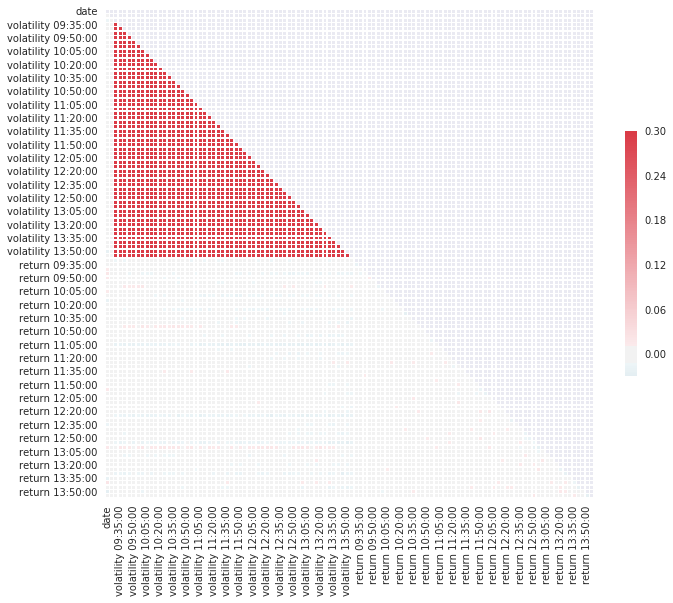

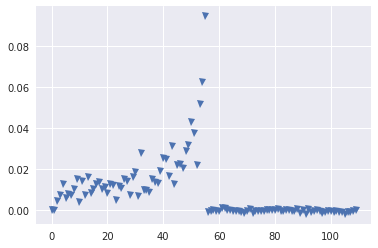

26.626416159702444


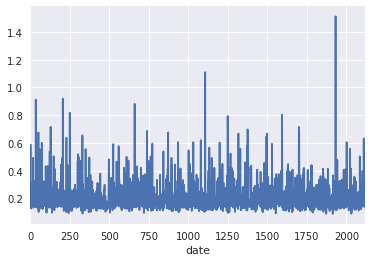

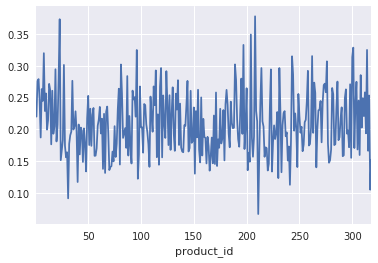

In [ ]:
for i in range(54)[::15]:
    train[vol_names[i]].hist(bins=2000, label=vol_names[i].split(" ")[1])

plt.xlim(0, 2.0)
plt.ylim(0, 27000)
plt.legend()
plt.show()

correlation_matrix(train)
plt.show()

X_train2, X_test2, y_train2, y_test2 = \
    train_test_split(train, result, test_size=0.30, random_state=42)
lr = LinearRegression().fit(X_train2, y_train2)
plt.plot(lr.coef_, 'v', label="LinearRegression")
plt.show()

print(score_function(y_test2, lr.predict(X_test2)))

temp_data_set = train
temp_data_set['sum_vol'] = train[vol_names].mean(axis=1)
date_vol = temp_data_set.groupby(['date'])['sum_vol'].mean()
stock_vol = temp_data_set.groupby(['product_id'])['sum_vol'].mean()

date_vol.plot()
plt.show()
stock_vol.plot()
plt.show()

### Feature engineering methods

In [67]:
def vanilla(data_set):
    return data_set

def best_wa(data_set):
    new_data_set = data_set.iloc[:,:2]
    new_data_set['sum_return'] = data_set[return_names].sum(axis=1)
    new_data_set['bwa'] = np.average(data_set[vol_names[-40:]], weights=best_weight, axis=1)
    return new_data_set

# 'date', 'product_id', 'sum_return', 'bwa', 'cum_vol'
def day_cum_vol(data_set):
    new_data_set = data_set.iloc[:,:2]
    temp_data_set = data_set
    temp_data_set['sum_vol'] = data_set[vol_names].sum(axis=1)
    new_data_set['sum_return'] = data_set[return_names].sum(axis=1)
    new_data_set['bwa'] = np.average(data_set[vol_names[-40:]], weights=best_weight, axis=1)
    date_vol = temp_data_set.groupby(['date'])['sum_vol'].sum(axis=0)
    new_data_set = pd.merge(new_data_set, pd.DataFrame({"date": date_vol.index,"cum_vol": date_vol}), how="left",\
                            on="date")
    return new_data_set

# 'sum_return', 'bwa', 'day_vol', 'stock_vol'
def stock_day_cum_vol(data_set, result_set):
    new_data_set = data_set.iloc[:,:2]
    new_data_set['sum_return'] = data_set[return_names].sum(axis=1)
    new_data_set['bwa'] = np.average(data_set[vol_names[-40:]], weights=best_weight, axis=1)
    # ------ group by ------
    temp_data_set = data_set
    temp_data_set['sum_vol'] = data_set[vol_names].sum(axis=1)
    date_vol = temp_data_set.groupby(['date'])['sum_vol'].median()
    stock_vol = temp_data_set.groupby(['product_id'])['sum_vol'].median()
    new_data_set = pd.merge(new_data_set, pd.DataFrame({"date": date_vol.index,"day_vol": date_vol}), how="left",\
                            on="date")
    new_data_set = pd.merge(new_data_set, pd.DataFrame({"product_id": stock_vol.index,"stock_vol": stock_vol}),\
                            how="left", on="product_id")
    return new_data_set

# 'sum_return', 'bwa', 'day_vol', 'stock_vol' , 'rl' 
def cumStock_cumDay_cumReturn_rl(data_set, result_set):
    new_data_set = data_set.iloc[:,:2]
    new_data_set['sum_return'] = data_set[return_names].sum(axis=1)
    new_data_set['bwa'] = np.average(data_set[vol_names[-40:]], weights=best_weight, axis=1)
    # ------ group by ------
    temp_data_set = data_set
    temp_data_set['sum_vol'] = data_set[vol_names].sum(axis=1)
    date_vol = temp_data_set.groupby(['date'])['sum_vol'].median()
    stock_vol = temp_data_set.groupby(['product_id'])['sum_vol'].median()
    new_data_set = pd.merge(new_data_set, pd.DataFrame({"date": date_vol.index,"day_vol": date_vol}), how="left",\
                            on="date")
    new_data_set = pd.merge(new_data_set, pd.DataFrame({"product_id": stock_vol.index,"stock_vol": stock_vol}),\
                            how="left", on="product_id")
    # ------ rl ------
    rl_set = data_set.iloc[:,:56]
    rl_set['min'] = data_set[vol_names].min(axis=1)
    rl_set['max'] = data_set[vol_names].max(axis=1)
    rl_set['median'] = data_set[vol_names].median(axis=1)
    rl_set['mean'] = data_set[vol_names].mean(axis=1)
    rl_set['std'] = data_set[vol_names].std(axis=1)
    rl_set = pd.merge(rl_set, pd.DataFrame({"date": date_vol.index,"day_vol": date_vol}), how="left",\
                                on="date")
    rl_set = pd.merge(rl_set, pd.DataFrame({"product_id": stock_vol.index,"stock_vol": stock_vol}),\
                            how="left", on="product_id")
    pipe = Pipeline([("scaler", StandardScaler()),("reg", LinearRegression())])
    lr = GridSearchCV(pipe, param_grid={}, cv=4, scoring=mape, n_jobs=-1)
    lr.fit(rl_set, result_set)
    new_data_set["rl"] = lr.predict(rl_set)
    return new_data_set

### Data size & Features model selection

# ---------------------------------------

In [92]:
work_with_subset = False
card_subset = 1000
test_size=0.3
feature_method = stock_day_cum_vol
feature_method = cumStock_cumDay_cumReturn_rl

if work_with_subset:
    current_train = pd.concat([train, result], axis=1)\
        .reindex(np.random.permutation(train.index))\
        .iloc[:card_subset]
    current_result = current_train.pop("TARGET")
else:
    current_train = train
    current_result = result

def split(preprocessed_method, test_size):
    preprocessed_data = preprocessed_method(current_train, current_result)
    return (*train_test_split(preprocessed_data, current_result, test_size=test_size, random_state=42),\
            preprocessed_data)

%time X_train, X_test, y_train, y_test, selected_model = split(feature_method, test_size)
print(X_train.shape)
print(X_test.shape)
print(X_test.columns)

/home/huguesvincent/.local/lib/python3.5/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/huguesvincent/.local/lib/python3.5/site-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CPU times: user 29.8 s, sys: 4.37 s, total: 34.2 s
Wall time: 37.9 s
(445419, 7)
(190894, 7)
Index(['date', 'product_id', 'sum_return', 'bwa', 'day_vol', 'stock_vol',
       'rl'],
      dtype='object')


In [69]:
p(len(selected_model.columns))
selected_model.describe()

7


,date,product_id,sum_return,bwa,day_vol,stock_vol,rl
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1043.907000,160.936000,0.074000,0.157958,10.950299,10.014729,0.175007
std,615.523055,90.385028,6.974035,0.117113,7.607408,3.781908,0.136213
min,8.000000,1.000000,-19.000000,0.017598,1.517389,3.784427,0.027509
25%,503.500000,83.000000,-5.000000,0.094880,6.855126,7.476583,0.105305
50%,1012.000000,164.000000,0.000000,0.130198,9.224492,9.280029,0.142911
75%,1600.000000,237.000000,5.000000,0.185305,12.925667,11.908171,0.207730
max,2115.000000,318.000000,21.000000,1.977552,153.698451,26.919050,2.578290


In [114]:
test_m = stock_day_cum_vol(test, None)

/home/huguesvincent/.local/lib/python3.5/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/huguesvincent/.local/lib/python3.5/site-packages/ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# ---------------------------------------

# Data exploration


### Algorithm

#### regression

In [90]:
pipe = Pipeline([("scaler", StandardScaler()),("reg", LinearRegression())])
#param_grid = {"reg__alpha": [0.01, 0.1, 1, 10, 100]}
param_grid = {}
lr = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring=mape, n_jobs=3)
%time lr.fit(X_train, y_train)
print_results(lr)

CPU times: user 121 ms, sys: 101 ms, total: 222 ms
Wall time: 346 ms
best_params {}
train:  25.065940661172704
test:  29.816148705296204


#### XgBoost

In [155]:
pipe_xgb = Pipeline([("scaler", StandardScaler()),("reg", xgboost.XGBRegressor(n_estimators=500, learning_rate=0.08, subsample=0.75,
                           colsample_bytree=1, max_depth=7))])
param_grid = {"reg__gamma": [0.01, 0.1, 1, 10, 100]}
param_grid = {}
xgb = GridSearchCV(pipe_xgb, param_grid=param_grid, cv=3, scoring=mape, n_jobs=3)
%time xgb.fit(X_train, y_train)
print_results(xgb)

CPU times: user 4min 5s, sys: 297 ms, total: 4min 5s
Wall time: 9min 8s
best_params {}
train:  21.237718177449697
test:  22.636905391599633


#### KNN regressor

In [83]:
pipe = Pipeline([("scaler", StandardScaler()),("reg", KNeighborsRegressor())])
param_grid = {}
knn = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring=mape, n_jobs=3)
%time knn.fit(X_train, y_train)
print_results(knn)

best_params {}
train:  28.791023191
test:  27.6743880089


#### AdaBoostRegressor

In [ ]:
params = {'n_estimators': 300}
pipe_adr = Pipeline([("adr", AdaBoostRegressor(n_estimators=300))])
param_grid = {"adr__n_estimators": [300]}
param_grid = {}
adr = GridSearchCV(AdaBoostRegressor(n_estimators=300), param_grid=param_grid, cv=3, scoring=mape, n_jobs=3)
%time adr.fit(X_train, y_train)
print_results(adr)

In [112]:
pipe_xgb2 = Pipeline([("scaler", StandardScaler()),("reg", xgboost.XGBRegressor(n_estimators=500, learning_rate=0.08, subsample=0.75,
                           colsample_bytree=1, max_depth=7))])
param_grid = {"reg__gamma": [0.01, 0.1, 1, 10, 100]}
param_grid = {}
xgb2 = GridSearchCV(pipe_xgb2, param_grid=param_grid, cv=3, scoring=mape, n_jobs=3)
%time xgb2.fit(x, y)



CPU times: user 3min 3s, sys: 183 ms, total: 3min 3s
Wall time: 6min 53s
39.445712810525166
45.97352613230992


In [113]:
p(score_function(y, xgb2.predict(x)))
p(score_function(y_t, xgb2.predict(x_t)))

4.424521909242941
25.06739140110626


#### Gradient boosting regressor

In [52]:
params = {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
pipe = Pipeline([("gbr", GradientBoostingRegressor(**params))])
gbr = GridSearchCV(pipe, param_grid={}, cv=3, scoring=mape, n_jobs=3)
%time gbr.fit(X_train, y_train)
print_results(gbr)

best_params {}
train:  27.7263265209
test:  28.6138416011


#### RandomForestRegressor

In [161]:
pipe_rfr = Pipeline([("scaler", MinMaxScaler()),("rfr", RandomForestRegressor(n_estimators=100,n_jobs=-1))])
rfr = GridSearchCV(pipe_rfr, param_grid={}, cv=3, scoring=mape)
%time rfr.fit(X_train, y_train)
print_results(rfr)

CPU times: user 29min 52s, sys: 5.42 s, total: 29min 58s
Wall time: 8min 14s
best_params {}
train:  8.780406542935069
test:  24.51862534068462


In [162]:
df_to_csv(rfr.predict(selected_model),"rf")

#### SVR

In [ ]:
pipe_svr = Pipeline([("scaler", MinMaxScaler()),("svr", SVR(kernel='rbf', cache_size=1000))])
param_grid = {}
param_grid = {"svr__C": [0.1], "svr__C": [1e1]}
svr = GridSearchCV(pipe_svr, param_grid=param_grid, cv=3, scoring=mape, n_jobs=-1)
%time svr.fit(X_train, y_train)
print_results(svr)

In [ ]:
df_to_csv(svr.predict(selected_model),"svr")

#### Neural network

In [94]:
from sklearn.neural_network import MLPRegressor
pipe_mlp = Pipeline([("scaler", MinMaxScaler()),("mlp", MLPRegressor())])
param_grid = {}
param_grid = {"mlp__hidden_layer_sizes":tuple([50]*25)}
mlp = GridSearchCV(pipe_mlp, param_grid=param_grid, cv=3, scoring=mape, n_jobs=-1)
%time mlp.fit(X_train, y_train)
print_results(mlp)

CPU times: user 15.3 s, sys: 11.7 s, total: 27 s
Wall time: 6min 14s
best_params {'mlp__hidden_layer_sizes': 50}
train:  23.75009148400844
test:  24.5817111687691


In [95]:
df_to_csv(mlp.predict(selected_model),"mlp")

In [77]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, KFold
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
seed = 1

X = selected_model[:150]
y = current_result[:150]
def loss(y_true, y_pred):
    return K.mean(np.abs((y_true - y_pred) / y_true))* 100
def baseline_model():
    model = Sequential()
    model.add(Dense(10, input_dim=7, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(60, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(600, activation='relu'))
    model.add(Dense(1))
    model.compile(loss=loss, optimizer='sgd', metrics = ['accuracy'])
    return model


estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=100, verbose=False)
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(estimator, X, y, cv=kfold)

%time estimator.fit(X_train, y_train)
prediction = estimator.predict(X_train)
p('score train: ', score_function(y_train, prediction))
prediction = estimator.predict(X_test)
p('score test: ', score_function(y_test, prediction))


CPU times: user 2.65 s, sys: 0 ns, total: 2.65 s
Wall time: 2.64 s
score train:  5721.967666392776
score test:  5375.791265154776


In [42]:
model.predict(X_train)[:,0]

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [25]:
model.fit(x_train, y_train, epochs=5, batch_size=32)
model.train_on_batch(x_batch, y_batch)
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)
classes = model.predict(x_test, batch_size=128)


# Miscellaneous

In [112]:
def best_weight_(data_set, nb_vol):
    v = X_train[vol_names[-nb_vol:]].values
    v_2 = a([[vol/y_train.iloc[i]**2 for vol in v[i]] for i in rl(v)])
    return inv(v_2.T @ v) @ v_2.T @ y_train.values
#weights = best_weight(selected_model, 40)
score_function(current_result, np.average(current_train[vol_names[-40 +n :]], weights=best_weight[n:], axis=1))


24.22418121352502